# Pedestrian flows in Newcastle City Centre

These graphs analyse the pedestrian count data obtained from a small number of CCTV cameras in the centre of Newcastle, processed in real-time using computer vision to count pedestrians that cross lines. The direction of travel is also obtained.

In [1]:
import matplotlib
import pandas as pd
import numpy as np
import json
import math
import pickle
import urllib.request
import dateutil.tz
import dateutil.parser
import dateutil.rrule
import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import sys
import gc
import re
from IPython.display import display, HTML
from textwrap import wrap

matplotlib.rcParams.update({
    'font.size': 13,
    'timezone': 'Europe/London'
})

In [2]:
# Used across most of the plots for people flows
tzLocal = dateutil.tz.gettz('Europe/London')
dateToday = datetime.datetime.combine(datetime.date.today(), datetime.datetime.min.time()).replace(tzinfo=tzLocal)
peopleCountInterval = 900
peopleCountFrames = pickle.load(open('../cache/recent-pedestrian-flows-pd.pkl', 'rb'))

dateBaselineEnd = datetime.datetime.strptime('2020-03-15T23:59:59Z', '%Y-%m-%dT%H:%M:%SZ').replace(tzinfo=tzLocal)

# TODO: Make this reflect the last entry in the frame, not the time now
print('Last data obtained %s' 
    % (np.max(list(map(lambda f: np.max(f.index), peopleCountFrames.values()))).strftime('%d %B %Y %H:%M')))

Last data obtained 28 August 2020 12:00


In [3]:
colourUp = '#f64a8a'
colourDown = '#233067'
# Ignore non-numeric columns in the dataframe
plottableTypes = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
perMinuteFactor = (peopleCountInterval / 60)

## Each camera compared to normal daily profiles and averages

Some of the cameras aren't processed in real-time so are skipped in these graphs.

* The shaded area represents a normal percentile boundary obtained for that day of the week during the last year before the outbreak.
* The dotted line represents the median, so an average on that day of the week.
* The solid line represents the actual observed data.

You can [download the underlying data as a CSV file](https://covid.view.urbanobservatory.ac.uk/output/recent-pedestrian-flows-pd.csv) or access it through [one of our APIs](https://newcastle.urbanobservatory.ac.uk/api_docs/).

In [4]:
lowerPercentileRange = 15
upperPercentileRange = 85

def plotDateAgainstProfile(plotDate):
    sensorList = sorted(peopleCountFrames.keys())
    sensorWithDataToday = []

    for sensorName in sensorList:
        dfSensorToday = peopleCountFrames[sensorName][peopleCountFrames[sensorName].index >= plotDate]
        if len(dfSensorToday.index) > 0:
            sensorWithDataToday.append(sensorName)
    sensorCount = len(sensorWithDataToday)

    gridWidth = 3
    gridHeight = math.ceil(sensorCount / gridWidth)

    fig = plt.figure(figsize=(15, 1 + gridHeight * 4), constrained_layout=True)
    #fig.subplots_adjust(wspace=0.2, hspace=0.5)
    gs = fig.add_gridspec(ncols=gridWidth, nrows=gridHeight)

    subPlotIdx = 0
    for sensorName in sensorWithDataToday:
        dfSensor = peopleCountFrames[sensorName].copy()
        dfSensor.insert(0, 'Day of week', dfSensor.index.to_series().apply(lambda t: t.strftime('%A')))
        dfSensor.insert(1, 'Time of day', dfSensor.index.to_series().apply(lambda t: t.strftime('%H:%M:%S')))

        # Scale for per-minute values
        for c in dfSensor.select_dtypes(plottableTypes).columns:
            dfSensor[c] = dfSensor[c] / perMinuteFactor

        # Fetch today's data only, but not within the last N minutes (might be misleading if half
        # way through a bucket)
        dfSensorToday = dfSensor.loc \
          [(plotDate <= dfSensor.index) &
           (dfSensor.index <= plotDate + pd.Timedelta(hours=24)) &
          (dfSensor.index < np.max(dfSensor.index) - pd.Timedelta(seconds=peopleCountInterval))]

        # Calculate an average and quartiles for every 15 minutes on each day of the week
        aggregateColumns = ['Day of week', 'Time of day']
        dfDailyProfile = dfSensor[ : dateBaselineEnd].groupby(aggregateColumns, group_keys=False, as_index=False).median()
        dfDailyLQ = dfSensor[ : dateBaselineEnd].groupby(aggregateColumns, group_keys=False, as_index=False).quantile(lowerPercentileRange / 100)
        dfDailyUQ = dfSensor[ : dateBaselineEnd].groupby(aggregateColumns, group_keys=False, as_index=False).quantile(upperPercentileRange / 100)
        for direction in dfDailyProfile.select_dtypes(plottableTypes).columns:
            dfDailyProfile['%s: Lower percentile' % direction] = dfDailyLQ[direction]
            dfDailyProfile['%s: Upper percentile' % direction] = dfDailyUQ[direction]

        # Determine the maximum this graph will reach on ANY day of the week
        sensorWeeklyMax = dfSensor \
            .groupby(aggregateColumns, group_keys=False, as_index=False) \
            .quantile(0.85) \
            .copy() \
            .select_dtypes(plottableTypes) \
            .max(axis=0) \
            .max(axis=0)
            
        ax = fig.add_subplot(gs[math.floor(subPlotIdx / gridWidth), subPlotIdx % gridWidth])

        timeLocator = mdates.AutoDateLocator(minticks=4, maxticks=6)
        ax.set_title('\n'.join(wrap(sensorName, 40)), fontsize=12)
        ax.set_xlabel('Date')
        ax.xaxis.set_major_locator(timeLocator)
        ax.xaxis.set_major_formatter(
            mdates.ConciseDateFormatter(
                locator=timeLocator,
                offset_formats=['', '%Y', '%b-%Y', '%d-%b-%Y', '%d-%b-%Y', '%d-%b-%Y %H:%M']
            )
        )
        ax.set_ylabel('Pedestrians per minute')
        ax.set_ylim([0.0, sensorWeeklyMax])
        ax.set_xlim([plotDate, plotDate + pd.Timedelta(hours=24)])

        # Generate an average series on this specific day with full timestamps
        dfTodayProfile = dfDailyProfile[dfDailyProfile['Day of week'] == plotDate.strftime('%A')].copy()
        dfTodayProfile['Timestamp'] = dfDailyProfile['Time of day'].apply(
          lambda timeOfDay: dateutil.parser.parse(
            '%sT%sZ' % (plotDate.strftime('%Y-%m-%d'), timeOfDay)
          )
        )

        lineColour = colourUp
        plotPercentileRange = []
        plotMedian = []
        for direction in dfSensorToday.select_dtypes(plottableTypes).columns:
            plotPercentileRange.append(ax.fill_between(
                dfTodayProfile['Timestamp'],
                dfTodayProfile['%s: Lower percentile' % direction],
                dfTodayProfile['%s: Upper percentile' % direction],
                color=lineColour,
                linewidth=0,
                alpha=0.2
            ))
            plotMedian.append(ax.plot(
                dfTodayProfile['Timestamp'],
                dfTodayProfile[direction],
                color=lineColour,
                linestyle=':',
                alpha=0.4
            )[0])
            ax.plot(
                dfSensorToday.index,
                dfSensorToday[direction],
                color=lineColour,
                label=direction
            )
            lineColour = colourDown if lineColour == colourUp else colourUp

        ax.legend(loc=2, prop={'size': 9})
        subPlotIdx = subPlotIdx + 1

    plt.figtext(
        0.05,
        -0.03,
        'Urban Observatory (https://www.urbanobservatory.ac.uk/).\n'
        'Luke Smith <luke.smith@ncl.ac.uk>.',
        horizontalalignment='left',
        color='#606060',
        fontdict={'size': 11}
    )
    plt.figlegend(
        plotPercentileRange[:2] + plotMedian[:2],
        [
            '/',
            '%u to %u%%ile for %ss during last year' 
              % (lowerPercentileRange, upperPercentileRange, plotDate.strftime('%A')),
            '/',
            'Median for %s' % plotDate.strftime('%A')
        ],
        loc='lower right',
        ncol=4,
        labelspacing=0,
        handletextpad=0.4,
        columnspacing=0.4
    )

    #plt.tight_layout()
    
    plt.suptitle('%s' % plotDate.strftime('%A %d %B %Y'), fontsize='15', fontweight='bold')
    #plt.subplots_adjust(top=0.92)
    
    plt.savefig('../output/pedestrian-flows_profile-comparison_%s.png' % plotDate.strftime('%d-%b-%Y'), bbox_inches='tight')
    plt.show()

### Today

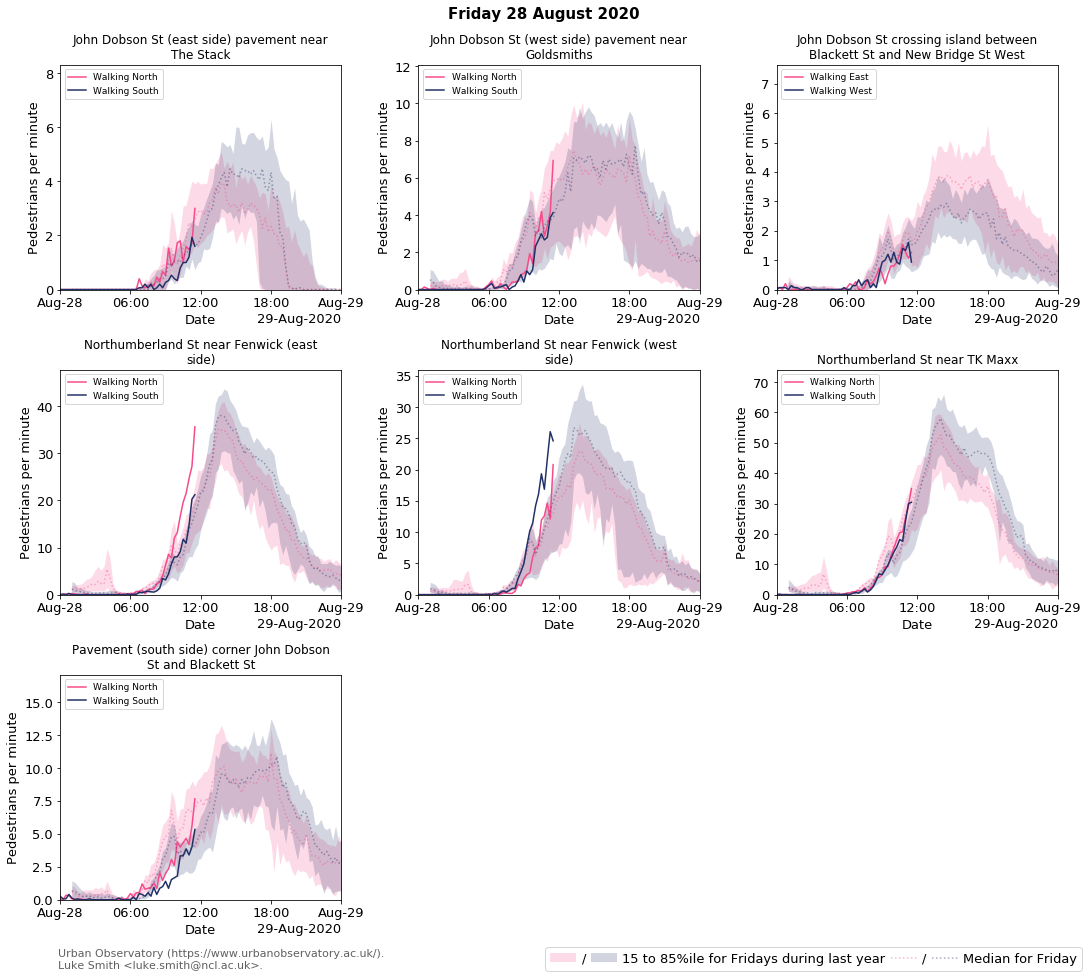

In [5]:
# Today
plotDateAgainstProfile(dateToday)

### Yesterday

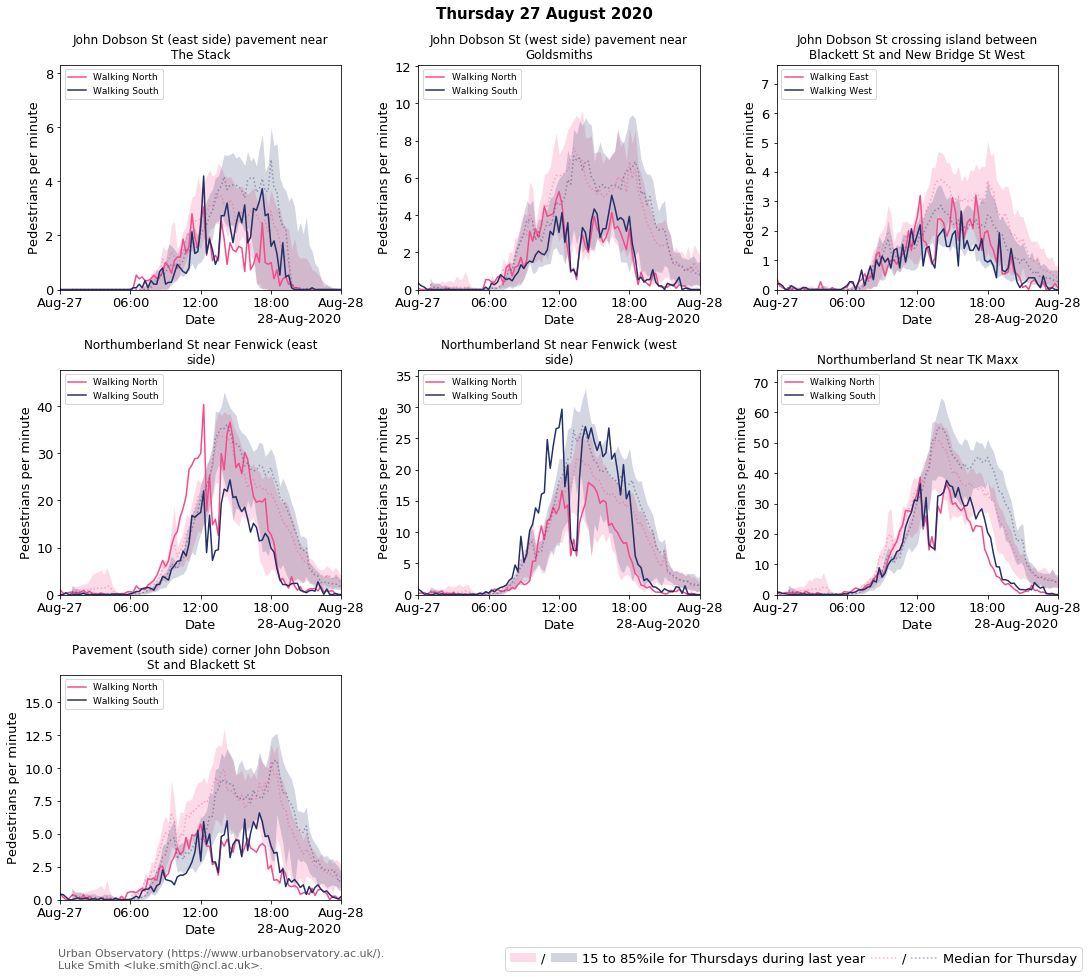

In [6]:
# Yesterday
plotDateAgainstProfile(dateToday - pd.Timedelta(hours=24))

In [7]:
# Last two weeks
#for d in range(14, 1, -1):
#    plotDateAgainstProfile(dateToday - pd.Timedelta(days=d))